WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


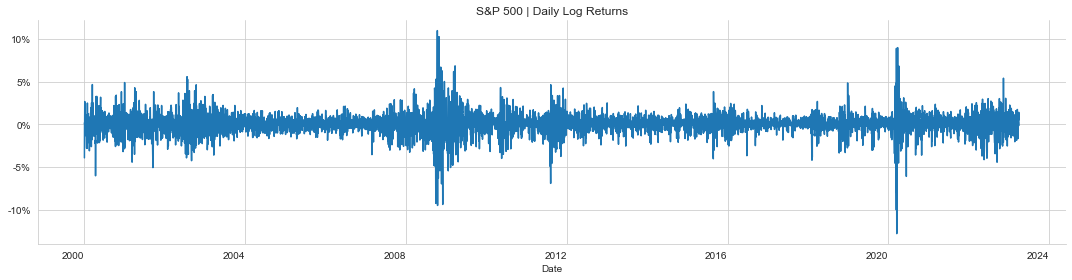

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import pymc3 as pm
import arviz
from pymc3.distributions.timeseries import GaussianRandomWalk
sns.set_style('whitegrid')
# model_path = Path('models')

prices = pd.read_hdf('data/assets.h5', key='sp500/stooq').loc['2000':, 'close']
log_returns = np.log(prices).diff().dropna()
ax = log_returns.plot(figsize=(15, 4), title='S&P 500 | Daily Log Returns', rot=0)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
plt.tight_layout();

In [3]:
# Specify Model in PyMC3

with pm.Model() as model:
    step_size = pm.Exponential('sigma', 50.)
    s = GaussianRandomWalk('s', sd=step_size, shape=len(log_returns))
    nu = pm.Exponential('nu', .1)
    r = pm.StudentT('r', nu=nu, lam=pm.math.exp(-2*s), observed=log_returns)

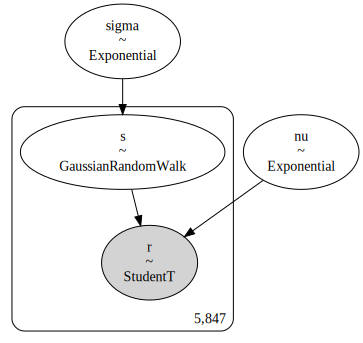

In [4]:
pm.model_to_graphviz(model)

In [5]:
# Fit Model
with model:
    trace = pm.sample(tune=2000, draws=5000, chains=4, cores=1, target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [nu, s, sigma]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 12087 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [6]:
with open('model_vol.pkl', 'wb') as buff:
    pickle.dump({'model': model, 'trace': trace}, buff)

In [7]:
# Trace Plot
# arviz.plot_trace(trace, var_names=['sigma', 'nu']);

In [8]:
# In-Sample Predictions
pm.trace_to_dataframe(trace).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 5849 entries, s__0 to nu
dtypes: float64(5849)
memory usage: 892.5 MB


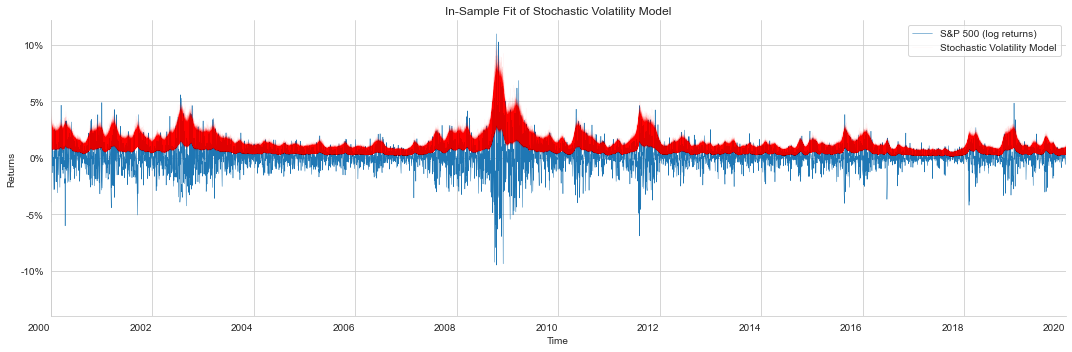

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))

log_returns.plot(ax=ax, lw=.5, xlim=('2000', '2020'), rot=0, title='In-Sample Fit of Stochastic Volatility Model')

ax.plot(log_returns.index, np.exp(trace[s]).T, 'r', alpha=.03, lw=.5)

ax.set(xlabel='Time', ylabel='Returns')
ax.legend(['S&P 500 (log returns)', 'Stochastic Volatility Model'])
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

sns.despine()
fig.tight_layout()